In [1]:
!pip install chainer==7.7.0

     |████████████████████████████████| 11.2 MB 3.6 MB/s 
  Created wheel for chainer: filename=chainer-7.7.0-py3-none-any.whl size=967522 sha256=6ae64e1a7dce7497652925338dfa55f91425fb4c3af1d2ce6d9d26ce1eea97c1
  Stored in directory: /root/.cache/pip/wheels/4f/c2/ca/e46a1181cc92ebe6e2d117a5cd29da5bcfc8464e00edb2cac0
Successfully built chainer


In [2]:
import chainer

In [3]:
import cv2
import csv
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # for image display
import numpy as np
import pandas as pd
from skimage import io
from PIL import Image 

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
%cd /content/
!rm -rf hyperface
!git clone https://github.com/alvaro-neira/hyperface.git --branch colab
%cd hyperface/
!git fetch --all
!git pull origin colab


/content
Cloning into 'hyperface'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 270 (delta 31), reused 33 (delta 14), pack-reused 218
Receiving objects: 100% (270/270), 8.33 MiB | 15.42 MiB/s, done.
Resolving deltas: 100% (158/158), done.
/content/hyperface
Fetching origin
From https://github.com/alvaro-neira/hyperface
 * branch            colab      -> FETCH_HEAD
Already up to date.


In [7]:
%cd /content/hyperface/scripts

/content/hyperface/scripts


In [16]:
pre_trained = '/content/drive/MyDrive/ai/model_epoch_190'

In [8]:
import chainer

import cv2
import os
import numpy as np

import config

# Disable type check in chainer
import models

os.environ["CHAINER_TYPE_CHECK"] = "0"


def _cvt_variable(v):
    # Convert from chainer variable
    if isinstance(v, chainer.variable.Variable):
        v = v.data
        if hasattr(v, 'get'):
            v = v.get()
    return v


def short_hyperface(config_path, img_path, model_path):
    # Load config
    config.load(config_path)

    # Define a model
    model = models.HyperFaceModel()
    model.train = False
    model.report = False
    model.backward = False

    # Initialize model
    chainer.serializers.load_npz(model_path, model)

    # Setup GPU
    if config.gpu >= 0:
        chainer.cuda.check_cuda_available()
        chainer.cuda.get_device(config.gpu).use()
        model.to_gpu()
        xp = chainer.cuda.cupy
    else:
        xp = np

    # Load image file
    img = cv2.imread(img_path)
    if img is None or img.size == 0 or img.shape[0] == 0 or img.shape[1] == 0:
        exit()
    img = img.astype(np.float32) / 255.0  # [0:1]
    img = cv2.resize(img, models.IMG_SIZE)
    img = cv2.normalize(img, None, -0.5, 0.5, cv2.NORM_MINMAX)
    img = np.transpose(img, (2, 0, 1))

    # Create single batch
    imgs = xp.asarray([img])
    x = chainer.Variable(imgs)  # , volatile=True)

    # Forward
    y = model(x)

    # Chainer.Variable -> np.ndarray
    detection = _cvt_variable(y['detection'])
    genders = _cvt_variable(y['gender'])

    gender = genders[0]

    if gender > 0.5:
        return f"Female, detection={detection[0]}"
    else:
        return f"Male, detection={detection[0]}"

In [17]:
print(short_hyperface('/content/hyperface/scripts/config.json','/content/drive/MyDrive/ai/faces1/tv24horas_2021_12_07_01_face1.png',pre_trained))

[2022/01/13 05:31:07] INFO (82) config : Load config from "/content/hyperface/scripts/config.json"
[2022/01/13 05:31:07] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:31:07] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:31:07] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:31:07] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:31:07] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:31:07] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:31:07] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:31:07] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:31:07] ERROR (82) config : Conflict in config with key "n_epoch"
[2022/01/13 05:31:07] ERROR (82) config : Conflict in config with key "batchsize"
[2022/01/13 05:31:07] ERROR (82) config

Male, detection=0.9749955534934998


In [18]:
%cd /content/hyperface/scripts

/content/hyperface/scripts


In [19]:
import chainer

import cv2
import os
import numpy as np

import config
from drawing import draw_pose, draw_gender, draw_detection, draw_landmark
import log_initializer
import models

# logging
from logging import getLogger, DEBUG

log_initializer.setFmt()
log_initializer.setRootLevel(DEBUG)
logger = getLogger(__name__)

# Disable type check in chainer
os.environ["CHAINER_TYPE_CHECK"] = "0"


def _cvt_variable(v):
    # Convert from chainer variable
    if isinstance(v, chainer.variable.Variable):
        v = v.data
        if hasattr(v, 'get'):
            v = v.get()
    return v


def frame_detect(img):
    # Load config
    config.load('config.json')

    # Define a model
    logger.info('Define a HyperFace model')
    model = models.HyperFaceModel()
    model.train = False
    model.report = False
    model.backward = False

    # Initialize model
    chainer.serializers.load_npz(pre_trained, model)

    xp = np

    if img is None or img.size == 0 or img.shape[0] == 0 or img.shape[1] == 0:
        logger.error('Failed to load')
        exit()
    frame = img.copy()
    frame = frame.astype(np.float32) / 255.0  # [0:1]
    frame = cv2.resize(frame, models.IMG_SIZE)
    frame = cv2.normalize(frame, None, -0.5, 0.5, cv2.NORM_MINMAX)
    frame = np.transpose(frame, (2, 0, 1))

    # Create single batch
    imgs = xp.asarray([frame])
    x = chainer.Variable(imgs)  # , volatile=True)

    y = model(x)

    # Chainer.Variable -> np.ndarray
    imgs = _cvt_variable(y['img'])
    detections = _cvt_variable(y['detection'])
    landmarks = _cvt_variable(y['landmark'])
    visibilities = _cvt_variable(y['visibility'])
    poses = _cvt_variable(y['pose'])
    genders = _cvt_variable(y['gender'])

    # Use first data in one batch
    frame = imgs[0]
    detection = detections[0]
    landmark = landmarks[0]
    visibility = visibilities[0]
    pose = poses[0]
    gender = genders[0]

    frame = np.transpose(frame, (1, 2, 0))
    frame = frame.copy()
    frame += 0.5  # [-0.5:0.5] -> [0:1]
    detection = (detection > 0.5)
    gender = (gender > 0.5)

    # Draw results
    draw_detection(frame, detection)
    landmark_color = (0, 1, 0) if detection == 1 else (0, 0, 1)
    draw_landmark(frame, landmark, visibility, landmark_color, 0.5)
    draw_pose(frame, pose)
    draw_gender(frame, gender)

    return frame

In [20]:
%cd /content/hyperface/

/content/hyperface


[2022/01/13 05:33:22] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:22] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:22] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:22] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:22] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:22] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:22] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:22] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:22] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:22] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:22] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:22] ERROR (82) config : Conflict in config with key "n_epo

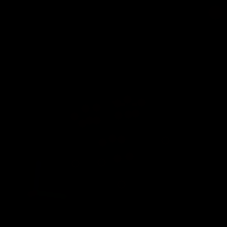

det_82.43_9.91.png





[2022/01/13 05:33:25] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:25] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:25] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:25] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:25] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:25] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:25] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:25] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:25] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:25] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:25] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:25] ERROR (82) config : Conflict in config with key "n_epo

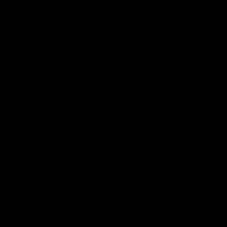

Copy of tv24horas_2021_12_18_06_face1.png





[2022/01/13 05:33:28] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:28] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:28] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:28] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:28] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:28] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:28] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:28] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:28] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:28] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:28] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:29] ERROR (82) config : Conflict in config with key "n_epo

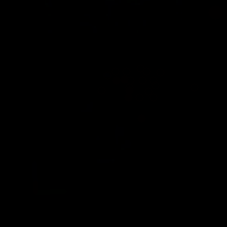

Copy of tv24horas_2021_12_19_23_face1.png





[2022/01/13 05:33:32] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:32] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:32] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:32] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:32] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:32] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:32] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:32] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:32] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:32] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:32] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:32] ERROR (82) config : Conflict in config with key "n_epo

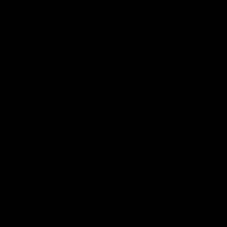

Copy of tv24horas_2021_12_17_17_face1.png





[2022/01/13 05:33:35] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:35] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:35] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:35] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:35] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:35] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:35] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:35] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:35] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:35] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:35] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:35] ERROR (82) config : Conflict in config with key "n_epo

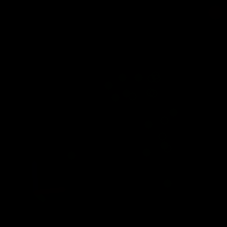

Copy of tv24horas_2021_12_31_23_face1.png





[2022/01/13 05:33:38] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:38] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:38] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:38] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:38] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:38] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:38] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:38] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:38] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:38] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:38] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:38] ERROR (82) config : Conflict in config with key "n_epo

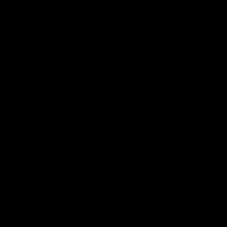

Copy of tv24horas_2021_12_17_19_face1.png





[2022/01/13 05:33:41] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:41] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:41] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:41] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:41] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:41] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:41] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:41] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:41] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:41] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:41] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:41] ERROR (82) config : Conflict in config with key "n_epo

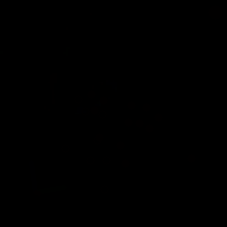

Copy of tv24horas_2021_12_19_10_face1.png





[2022/01/13 05:33:44] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:44] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:44] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:44] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:44] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:44] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:44] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:44] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:44] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:44] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:44] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:44] ERROR (82) config : Conflict in config with key "n_epo

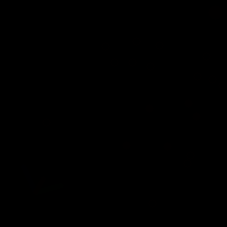

Copy of tv24horas_2021_12_22_11_face1.png





[2022/01/13 05:33:47] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:47] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:47] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:47] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:47] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:47] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:47] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:47] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:47] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:47] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:47] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:47] ERROR (82) config : Conflict in config with key "n_epo

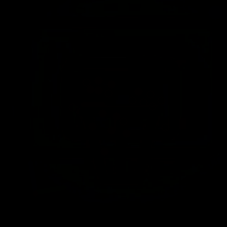

Copy of tv24horas_2021_12_25_16_face1.png





[2022/01/13 05:33:50] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:50] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:50] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:50] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:50] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:50] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:50] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:50] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:50] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:50] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:50] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:50] ERROR (82) config : Conflict in config with key "n_epo

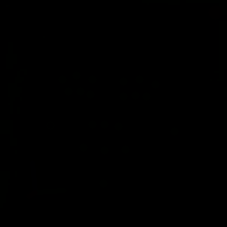

Copy of tv24horas_2021_12_19_17_face1.png





[2022/01/13 05:33:53] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:53] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:53] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:53] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:53] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:53] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:53] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:53] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:53] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:53] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:53] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:53] ERROR (82) config : Conflict in config with key "n_epo

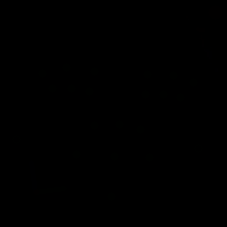

Copy of tv24horas_2021_12_26_16_face1.png





[2022/01/13 05:33:56] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:56] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:56] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:56] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:56] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:56] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:56] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:56] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:56] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:56] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:56] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:56] ERROR (82) config : Conflict in config with key "n_epo

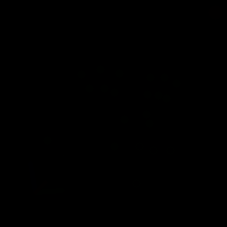

Copy of tv24horas_2021_12_27_18_face1.png





[2022/01/13 05:33:59] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:33:59] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:33:59] INFO (82) config : Load config from "config.json"
[2022/01/13 05:33:59] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:33:59] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:33:59] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:33:59] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:33:59] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:33:59] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:33:59] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:33:59] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:33:59] ERROR (82) config : Conflict in config with key "n_epo

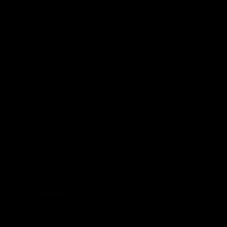

Copy of tv24horas_2021_12_26_22_face1.png





[2022/01/13 05:34:02] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:34:02] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:34:02] INFO (82) config : Load config from "config.json"
[2022/01/13 05:34:02] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:34:02] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:34:02] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:34:02] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:34:02] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:34:02] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:34:02] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:34:02] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:34:02] ERROR (82) config : Conflict in config with key "n_epo

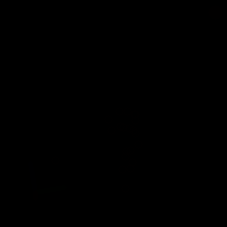

Copy of tv24horas_2021_12_29_21_face1.png





[2022/01/13 05:34:05] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:34:05] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:34:05] INFO (82) config : Load config from "config.json"
[2022/01/13 05:34:05] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:34:05] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:34:05] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:34:05] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:34:05] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:34:05] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:34:05] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:34:05] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:34:05] ERROR (82) config : Conflict in config with key "n_epo

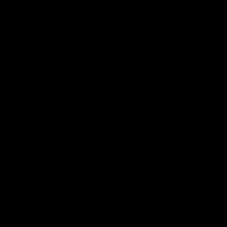

Copy of tv24horas_2021_12_30_16_face1.png





[2022/01/13 05:34:08] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:34:08] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:34:08] INFO (82) config : Load config from "config.json"
[2022/01/13 05:34:08] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:34:08] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:34:08] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:34:08] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:34:08] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:34:08] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:34:08] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:34:08] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:34:08] ERROR (82) config : Conflict in config with key "n_epo

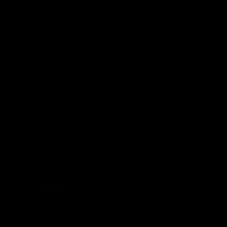

Copy of tv24horas_2021_12_27_12_face1.png





[2022/01/13 05:34:11] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:34:11] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:34:11] INFO (82) config : Load config from "config.json"
[2022/01/13 05:34:11] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:34:11] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:34:11] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:34:11] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:34:11] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:34:11] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:34:11] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:34:11] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:34:11] ERROR (82) config : Conflict in config with key "n_epo

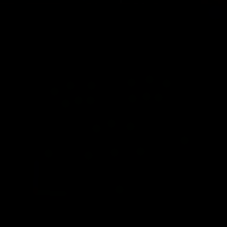

Copy of tv24horas_2021_12_28_01_face1.png





[2022/01/13 05:34:14] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:34:14] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:34:14] INFO (82) config : Load config from "config.json"
[2022/01/13 05:34:14] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:34:14] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:34:14] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:34:14] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:34:14] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:34:14] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:34:14] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:34:14] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:34:14] ERROR (82) config : Conflict in config with key "n_epo

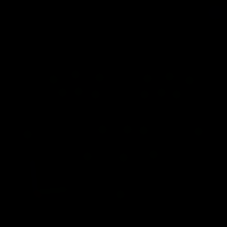

Copy of tv24horas_2021_12_28_19_face1.png





[2022/01/13 05:34:17] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:34:17] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:34:17] INFO (82) config : Load config from "config.json"
[2022/01/13 05:34:17] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:34:17] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:34:17] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:34:17] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:34:17] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:34:17] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:34:17] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:34:17] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:34:17] ERROR (82) config : Conflict in config with key "n_epo

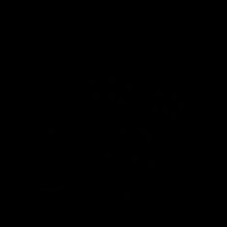

Copy of tv24horas_2021_12_29_06_face1.png





[2022/01/13 05:34:20] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:34:20] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:34:20] INFO (82) config : Load config from "config.json"
[2022/01/13 05:34:20] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:34:20] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:34:20] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:34:20] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:34:20] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:34:20] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:34:20] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:34:20] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:34:20] ERROR (82) config : Conflict in config with key "n_epo

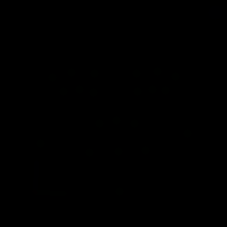

Copy of tv24horas_2021_12_29_24_face1.png





[2022/01/13 05:34:23] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:34:23] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:34:23] INFO (82) config : Load config from "config.json"
[2022/01/13 05:34:23] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:34:23] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:34:23] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:34:23] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:34:23] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:34:23] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:34:23] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:34:23] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:34:23] ERROR (82) config : Conflict in config with key "n_epo

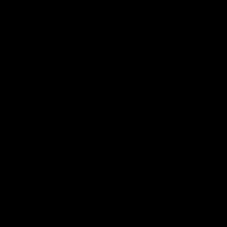

Copy of tv24horas_2021_12_27_23_face1.png





[2022/01/13 05:34:26] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:34:26] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:34:26] INFO (82) config : Load config from "config.json"
[2022/01/13 05:34:26] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:34:26] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:34:26] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:34:26] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:34:26] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:34:26] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:34:26] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:34:26] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:34:26] ERROR (82) config : Conflict in config with key "n_epo

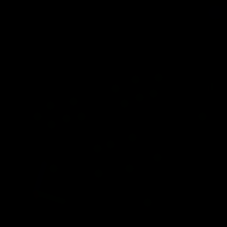

Copy of tv24horas_2021_12_30_19_face1.png





[2022/01/13 05:34:29] DEBUG (82) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 05:34:29] DEBUG (82) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 05:34:29] INFO (82) config : Load config from "config.json"
[2022/01/13 05:34:29] ERROR (82) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 05:34:29] ERROR (82) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 05:34:29] ERROR (82) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 05:34:29] ERROR (82) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 05:34:29] ERROR (82) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 05:34:29] ERROR (82) config : Conflict in config with key "gpu"
[2022/01/13 05:34:29] ERROR (82) config : Conflict in config with key "n_loaders_train"
[2022/01/13 05:34:29] ERROR (82) config : Conflict in config with key "n_loaders_test"
[2022/01/13 05:34:29] ERROR (82) config : Conflict in config with key "n_epo

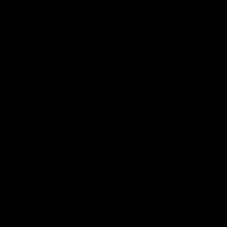

Copy of tv24horas_2021_12_31_05_face1.png





In [21]:
for filename in os.listdir("/content/drive/MyDrive/ai/faces"):
    if not filename.endswith(".png"): 
        continue
    img_path = os.path.join("/content/drive/MyDrive/ai/faces", filename)
    image_swapped = io.imread(f"{img_path}") 
    image_2 = cv2.cvtColor(image_swapped, cv2.COLOR_BGR2RGB)
    image3 = frame_detect(image_2)
    cv2_imshow(image3)
    print(filename)
    print('\n\n') 